# Characteristics of Avalanche Occurrence
Date: 06-02-2021
Author: Marta Ferrer 

This project tries to find how the features of an avalanche correlate and thier influence to the Avalanche Danger Level. 
The Avalanche Observation data set(Schweizer et al., 2020) is analysed by following the CRISP-DM process. We are going to try to find the answers of the following questions:
- Is there a relation between different characteristics of avalanches?
- What defines the avalanche danger level?
- How the danger relates to avalanche snow type, trigger type and size?

Let's get started!

## 1. Data Understanding

We are be using the data set provided by SLF (Schnee und Lawinenforschung) institute and available [here](https://www.envidat.ch/dataset/snow-avalanche-data-davos). 

The meaning of the data set columns can be found in [this](https://www.envidat.ch/dataset/snow-avalanche-data-davos/resource/f8d6835f-3ef6-4fe6-94a2-6b7f7b5827ce) pdf and some more glossary about avalanches and their main features can be read [here](https://www.avalanches.org/glossary/#amountoffreshfallensnow)

In [33]:
# Import libraries
import pandas as pd
from pandas.api.types import CategoricalDtype
import libs.Definitions as definition
import libs.Utils as utils

%matplotlib inline

In [20]:
# Load data 
df = pd.read_csv('./Dataset/data_set_1_avalanche_observations_wi9899_to_wi1819_davos.csv', delimiter=';')
df.head()

,no,x,snow_type,trigger_type,max_elevation_m,min_elevation_m,aspect_degrees,length_m,width_m,perimeter_length_m,area_m2,aval_size_class,weight_AAI,max.danger.corr
0,1,06/11/1998,dry,NATURAL,2476.0,2439.0,4.0,63.0,33.0,168.0,1413.0,2,0.1,NaN
1,2,07/12/1998,dry,NATURAL,2562.0,2484.0,42.0,101.0,123.0,355.0,8762.0,2,0.1,3.0
2,3,07/12/1998,dry,NATURAL,2494.0,2356.0,21.0,127.0,351.0,834.0,30522.0,3,1.0,3.0
3,4,07/12/1998,dry,HUMAN,2115.0,2017.0,200.0,166.0,85.0,454.0,7837.0,2,0.1,3.0
4,5,07/12/1998,dry,NATURAL,2085.0,1986.0,42.0,128.0,18.0,265.0,1522.0,2,0.1,3.0


In [5]:
# Dataset overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13918 entries, 0 to 13917
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   no                  13918 non-null  int64  
 1   x                   13918 non-null  object 
 2   snow_type           13918 non-null  object 
 3   trigger_type        13918 non-null  object 
 4   max_elevation_m     13896 non-null  float64
 5   min_elevation_m     13896 non-null  float64
 6   aspect_degrees      13802 non-null  float64
 7   length_m            13802 non-null  float64
 8   width_m             13802 non-null  float64
 9   perimeter_length_m  13802 non-null  float64
 10  area_m2             13802 non-null  float64
 11  aval_size_class     13918 non-null  int64  
 12  weight_AAI          13918 non-null  float64
 13  max.danger.corr     13745 non-null  float64
dtypes: float64(9), int64(2), object(3)
memory usage: 1.5+ MB


In [21]:
# Print another initesting features
print('Avalanche days:', len(df['x'].unique()))

Avalanche days: 1365


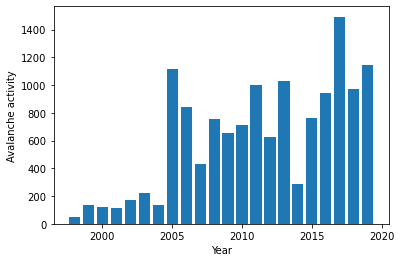

In [39]:
# Check how many avalanches are per year of preparing the dataset
utils.create_bar_plot(df, 'year', 'Year', 'Avalanche activity', True)

The data set includes 13'917 avalanches spread within 1'365 days. 
As stated in the data set information during the first 7 years the amount of avalanches reported are much less than the years after. 

## 2. Prepare Data
In this section we are going to clean and rework the data set. For that we are going to identify the:
- Missing values
- Categorical variables

In [22]:
# Check if there are missing values in any of the rows or columns.
print('Columns with missing val: ', set(df.columns[df.isnull().any()]))

for missing_val_col in set(df.columns[df.isnull().any()]):
    # Check how many missing values has every column
    missing_val = df[df[missing_val_col].isna() == True].shape[0]
    print('{} column has {} entries with null values'.format(missing_val_col, missing_val))
    
    missing_val_tot += missing_val
    
print('We are missing {}% of the avalanche danger level values'.format(missing_val_tot/(df.shape[0])*100))

Columns with missing val:  {'aspect_degrees', 'width_m', 'max_elevation_m', 'perimeter_length_m', 'area_m2', 'max.danger.corr', 'length_m', 'min_elevation_m'}
aspect_degrees column has 116 entries with null values
width_m column has 116 entries with null values
max_elevation_m column has 22 entries with null values
perimeter_length_m column has 116 entries with null values
area_m2 column has 116 entries with null values
max.danger.corr column has 173 entries with null values
length_m column has 116 entries with null values
min_elevation_m column has 22 entries with null values
We are missing 17.179192412702974% of the avalanche danger level values


### 2.1. Missing values

From the missing values list we can get the following conlcusions:

1. There are 4 columns related to the avalanche size in which 116 values are missing. In the dataset instructions is mentioned that those avalanches which are too small to derive meaningful values of length and width are set to null. Nonetheless, they were still assigned an avalanche size of 1. Since the information is given in other columns and those missing values are only related to specific domain, this rows might be usefull for different purposes.  

2. The column associeted to avalanche danger level has 173 rows with missing values. Since during this project we will continously check this informtation and it would be risky to impute those values (for the scope and time of the project), we will drop them.

3. The min and may elevation of the avalanche column has 22 entries with null values. For this first analysis those features are not taken into account. Therefore, we can drop them as well.  


In [23]:
# Drop missing values of the selected columns
df.dropna(subset=['max.danger.corr', 'min_elevation_m', 'max_elevation_m'], axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)

### 2.2 Categorical variables

Having a look in the columns there are those columns which are of type categorical:
- Snow type (wet, dry or mixed)
- Trigger type (human, explosive, natural)

In addition to this, we will create a new column called 'season' as categorical variable.
- Season (winter, spring, summer, autumn)


In [24]:
# Read the 'date' column and create three columns out of it: day, month and year
date = pd.to_datetime(df['x'])
date_df = pd.concat([pd.DataFrame(date.array.year),pd.DataFrame(date.array.month),pd.DataFrame(date.array.day)], axis=1)

date_df.columns = ['year', 'month', 'day']
df = pd.concat([date_df, df], axis=1)

# Group by season categorical value created from the month of release
df.insert(3, "season", None, True)
df.loc[[x in definition.winter for x in df['month']], 'season'] = 'winter'
df.loc[[x in definition.spring for x in df['month']], 'season'] = 'spring'
df.loc[[x in definition.summer for x in df['month']], 'season'] = 'summer'
df.loc[[x in definition.autumn for x in df['month']], 'season'] = 'autumn'

print(df['season'].unique())

['summer' 'autumn' 'winter' 'spring']


In [25]:
# Set type of snow column as categorical
snow_type = list(df['snow_type'].unique())
df.snow_type = df['snow_type'].astype(CategoricalDtype(categories=snow_type, ordered=False))
df.snow_type = df['snow_type'].str.upper()

print(df['snow_type'].unique())

['DRY' 'UNKNOWN' 'WET' 'MIXED']


In [26]:
# Set avalanche trigger type column as categorical
trigger = list(df['trigger_type'].unique())
df.trigger_type = df['trigger_type'].astype(CategoricalDtype(categories=trigger, ordered=False))
df.trigger_type = df['trigger_type'].str.upper()

print(df['trigger_type'].unique())

['NATURAL' 'HUMAN' 'UNKNOWN' 'EXPLOSIVE']


In [28]:
# Save cleaned and reworked data frame to csv file
df.to_csv('avalanche_observarions_clean.csv', index=False)

## Data Analysis and Visualization

In this section we are going to answer the pre-defined questions by analysing and visualising the previously cleaned data. 

In [30]:
# Load cleaned data
df = pd.read_csv('avalanche_observarions_clean.csv')
df.head()

,year,month,day,season,no,x,snow_type,trigger_type,max_elevation_m,min_elevation_m,aspect_degrees,length_m,width_m,perimeter_length_m,area_m2,aval_size_class,weight_AAI,max.danger.corr
0,1998,7,12,summer,2,07/12/1998,DRY,NATURAL,2562.0,2484.0,42.0,101.0,123.0,355.0,8762.0,2,0.1,3.0
1,1998,7,12,summer,3,07/12/1998,DRY,NATURAL,2494.0,2356.0,21.0,127.0,351.0,834.0,30522.0,3,1.0,3.0
2,1998,7,12,summer,4,07/12/1998,DRY,HUMAN,2115.0,2017.0,200.0,166.0,85.0,454.0,7837.0,2,0.1,3.0
3,1998,7,12,summer,5,07/12/1998,DRY,NATURAL,2085.0,1986.0,42.0,128.0,18.0,265.0,1522.0,2,0.1,3.0
4,1998,7,12,summer,6,07/12/1998,DRY,NATURAL,2605.0,2529.0,240.0,127.0,63.0,324.0,5929.0,2,0.1,3.0


### a) Avalanche features correlation
In order to have an overview of the dataset, we are going to create a correlation map displaying the relation between a pre-selected pairs of features. 

Index(['year', 'month', 'day', 'no', 'x', 'max_elevation_m', 'min_elevation_m',
       'aspect_degrees', 'length_m', 'width_m', 'perimeter_length_m',
       'area_m2', 'aval_size_class', 'weight_AAI', 'max.danger.corr',
       'snow_type_DRY', 'snow_type_MIXED', 'snow_type_UNKNOWN',
       'snow_type_WET', 'trigger_type_EXPLOSIVE', 'trigger_type_HUMAN',
       'trigger_type_NATURAL', 'trigger_type_UNKNOWN', 'season_autumn',
       'season_spring', 'season_summer', 'season_winter'],
      dtype='object')


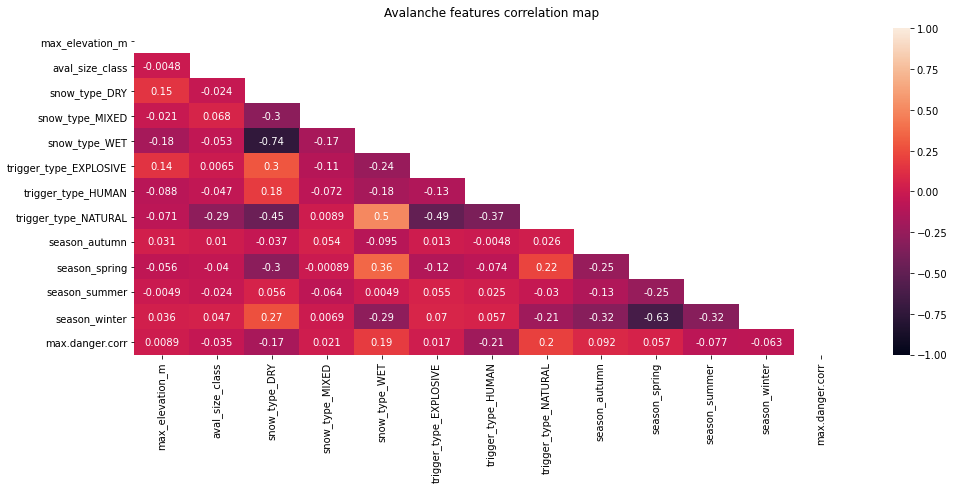

In [37]:
# Create one column for each category of the categorical variables
correlation_df = utils.create_dummy_df(df, ['snow_type', 'trigger_type', 'season'], False)
print(correlation_df.columns)

# Select a subset of columns to display
selected_col = ['max_elevation_m', 'aval_size_class', 
                'snow_type_DRY', 'snow_type_MIXED', 'snow_type_WET',
                'trigger_type_EXPLOSIVE', 'trigger_type_HUMAN', 'trigger_type_NATURAL',
                'season_autumn', 'season_spring', 'season_summer', 'season_winter',
                'max.danger.corr']
correlation_df = correlation_df[selected_col]

utils.create_correlation_map(df=correlation_df, title='Avalanche features correlation map')

**What can we say about the heatmap?**

Due to we are working with categorical values (e.g. _trigger_type_HUMAN_, _trigger_type_NATURAL_, _trigger_type_EXPLOSIVE_) the correlation coefficients between values from the same category are meaningless.

Even though there are no major dependencies between features, there are some which are more correlated than others. For instance, we can state that the snow type _WET_ is associated to the season _SPRING_ whereas the snow type _DRY_ is linked to _WINTER_, which makes a lot of sense. 
Surprisingly to my expectations, the avalanche size has not shown much correlation with respect to the avalanche danger level. This may suggest that this feature might remain to a secondary importance when assessing the risk level. 

### b) Avalanche danger level
The European avalanche danger scale ranges from 1-Low to 5-Very High and it is based on the snowpack stability and the avalanche triggering probability. In addition, the Avalanche Activity Index (AAI) is a useful parameter when assessing avalange danger since it indicates the number of avalanches per day.

Let's check the avalanche danger per season and per AAI.

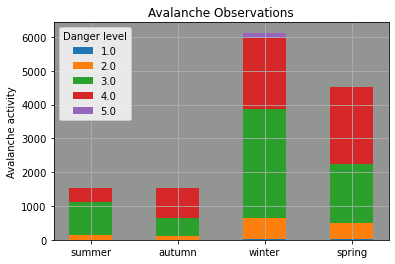

In [40]:
# Plot the avalanche danger level (stacked in the 5 different levels) per season type (winter, spring, summer and autum)
utils.create_stacked_bar_plot(df, 'max.danger.corr', 'season')

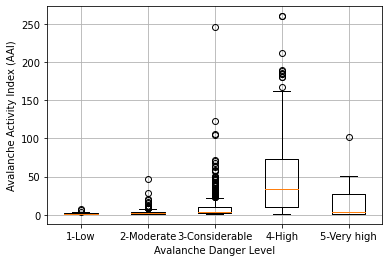

In [41]:
data_box_plot=[]
for i in sorted(df['max.danger.corr'].unique()):
    # Take a subset of specific avalanche danger level
    df_av_freq = df[df['max.danger.corr'] == i]

    # Gather the data to create the box plot
    data_box_plot.append(df_av_freq['x'].value_counts().values)

# Box plot
utils.create_box_plot(data_box_plot)

**What can we say about the plots?**

As shown in the box plot, the AAI mean per ascending danger level is 1.73, 2.95, 8.85, 46.91 and 27.33, respectively. Hence, there is a tendance of higher  AAI with higher risk.

The danger level _5-Very High_ is documented to be most likely incomplete, so it might be the reason why it does not follow the mentioned tendancy.

Last but not least, another interesting plot would be to show how many avalanches has been released within all days in a specific danger level. Unfortunately, the data set does not contain the danger information of those days in which any avalanche was released (AAI=0).


### b) Avalanche danger level related to snow and trigger type and size
